<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/NEURAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Upload cleaned dataset


In [3]:
import pandas as pd
from google.colab import files

# Carica il file CSV
uploaded = files.upload()  # Ti verrà chiesto di selezionare il file dal tuo computer



Saving cleaned_dataset_NN.csv to cleaned_dataset_NN.csv


In [4]:
# Leggi il file CSV con Pandas
for filename in uploaded.keys():
    df = pd.read_csv(filename)

df.head()

,id,Start,End,Label
0,Ventricular,0,11,B-Multi-tissue_structure
1,fibrillation,12,24,O
2,long,32,36,O
3,QT,37,39,O
4,syndrome,40,48,O


#Data preprocessing

In [5]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
# Definizione dei gruppi di token e delle etichette**
sequence_length = 10  # Definisci il numero di token per frase
df['Group'] = df.index // sequence_length  # Crea un gruppo ogni 10 token

# Gruppo delle sequenze e delle etichette
sentences = df.groupby('Group')['id'].apply(list).tolist()  # Liste di token per gruppo
labels = df.groupby('Group')['Label'].apply(list).tolist()  # Liste di etichette per gruppo

#Tokenizzazione delle sequenze**
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)  # Addestra il tokenizer sulle sequenze di token

# Converti i token in ID numerici
X = tokenizer.texts_to_sequences(sentences)

#Codifica delle etichette con LabelEncoder**
# Addestra il LabelEncoder su tutte le etichette del dataset
label_encoder = LabelEncoder()
label_encoder.fit(df['Label'])  # Usa tutte le etichette presenti nella colonna 'Label'

# Converte le etichette in ID numerici per ogni frase
y = [label_encoder.transform(sentence) for sentence in labels]

#Applicazione del padding**
# Lunghezza massima delle sequenze (per token e etichette)
max_sequence_len = 10  # Usa 10 come lunghezza massima (già definita)

# Applica il padding alle sequenze di token
X_padded = pad_sequences(X, maxlen=max_sequence_len, padding='post')

# Applica il padding alle sequenze di etichette
y_padded = pad_sequences(y, maxlen=max_sequence_len, padding='post')

# **5. Verifiche**
print(f"Shape di X_padded: {X_padded.shape}")
print(f"Shape di y_padded: {y_padded.shape}")

# Esempio di sequenze
print("\nEsempio di sequenza tokenizzata e con padding (X_padded):")
print(X_padded[:3])  # Mostra le prime 3 sequenze

# Esempio di etichette
print("\nEsempio di etichette con padding (y_padded):")
print(y_padded[:3])  # Mostra le prime 3 etichette

# Visualizza i token originali per la prima sequenza
print("\nToken originali per la prima sequenza (X_padded):")
print([tokenizer.index_word[idx] for idx in X_padded[0] if idx != 0])  # Ignora i padding (0)

# Visualizza le etichette originali per la prima sequenza
print("\nEtichette originali per la prima sequenza (y_padded):")
original_labels = [
    label_encoder.inverse_transform([idx])[0] for idx in y_padded[0] if idx != 0
]
print(original_labels)


Shape di X_padded: (6098, 10)
Shape di y_padded: (6098, 10)

Esempio di sequenza tokenizzata e con padding (X_padded):
[[1187 2898  309 1740  259 2026  463 2899 2900 1740]
 [  36  397 6456  432   58  886  819 6457  887  888]
 [ 173 1740   36  397 2900   49 2899  525  889 1187]]

Esempio di etichette con padding (y_padded):
[[ 5 22 22 22 22 22 22 22 22 22]
 [22 22 22 22 22 22 22 22 22 22]
 [22 22 22 22 22 22 22 22 22  5]]

Token originali per la prima sequenza (X_padded):
['ventricular', 'fibrillation', 'long', 'qt', 'syndrome', 'probably', 'caused', 'clindamycin', 'prolongation', 'qt']

Etichette originali per la prima sequenza (y_padded):
['B-Multi-tissue_structure', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


The code prepares the data for a sequential classification model. It begins by dividing tokens into fixed-length groups (10 tokens per sentence), creating a list of sequences and corresponding labels for each group. The tokens are then converted into numerical IDs through tokenization using a `Tokenizer`, which handles unknown words with the `<OOV>` token. Labels are transformed into consistent numerical IDs using a `LabelEncoder` trained on the entire dataset. Both token sequences and labels are then padded to a uniform length of 10 using post-padding to ensure compatibility with the model. Finally, the code validates the output by displaying examples of tokenized and padded sequences, along with their original decoded values for verification.

#Splitting dataset

We allocate 70% of the dataset for training, 15% for testing, and the remaining 15% for validation. This ensures a balanced approach, with a majority of the data used for model learning, while reserving sufficient portions for unbiased performance evaluation and hyperparameter tuning.

In [7]:
# Esegui lo split su X_padded e y_padded
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_padded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")

Train set: X=(4268, 10), y=(4268, 10)
Validation set: X=(915, 10), y=(915, 10)
Test set: X=(915, 10), y=(915, 10)


#Rebalancing dataset

We compute class weights to address the dataset's imbalance. The labels are converted into a one-dimensional array, unique classes are identified, and each class is assigned a weight inversely proportional to its relative frequency. For instance, class `0` has a weight of **47.58**, reflecting its low frequency, while class `22`, with a weight of **0.047**, is the most represented. These weights will be utilized during training to ensure balanced learning across the different classes.

In [8]:
# Converti y_train in un array 1D per calcolare i pesi
y_train_flat = y_train.flatten()
unique_labels = np.unique(y_train_flat)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=y_train_flat
)

class_weights_dict = dict(enumerate(class_weights))
print("Pesi delle classi:", class_weights_dict)

Pesi delle classi: {0: 47.58082497212932, 1: 3.3495526604928583, 2: 13.446754883427852, 3: 88.36438923395445, 4: 40.34026465028355, 5: 4.034026465028355, 6: 7.277067348678602, 7: 14.727398205659075, 8: 8.921404682274247, 9: 7.277067348678602, 10: 15.860274990709774, 11: 92.78260869565217, 12: 5.674777290253956, 13: 36.38533674339301, 14: 463.9130434782609, 15: 142.74247491638795, 16: 6.82225063938619, 17: 43.15470171890799, 18: 142.74247491638795, 19: 35.68561872909699, 20: 11.314952279957582, 21: 24.416475972540045, 22: 0.04706671166014923}


We convert the labels into one-hot encoding, which is required for the model and loss functions like categorical_crossentropy. We calculate the total number of classes, transforming numerical labels into binary vectors and verifying the array dimensions to ensure correctness.

In [9]:
# Numero di classi
num_classes = len(label_encoder.classes_)

# Convertire le etichette in formato one-hot
y_train = np.array([to_categorical(seq, num_classes=num_classes) for seq in y_train])
y_val = np.array([to_categorical(seq, num_classes=num_classes) for seq in y_val])
y_test = np.array([to_categorical(seq, num_classes=num_classes) for seq in y_test])

# Verifica delle nuove shape
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


y_train shape: (4268, 10, 23)
y_val shape: (915, 10, 23)
y_test shape: (915, 10, 23)


#Neural Network Approach
##Embedding  
###GloVe

In [10]:
# Scarica il file GloVe e decomprimilo
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

# Specifica il percorso del file GloVe
glove_path = 'glove.6B.100d.txt'

# Funzione per caricare i vettori pre-addestrati GloVe
def load_glove(glove_path):
    embedding_dict = {}
    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embedding_dict[word] = vector
    return embedding_dict

# Carica i vettori GloVe
embedding_dict = load_glove(glove_path)
print(f"Numero di parole caricate da GloVe: {len(embedding_dict)}")


# Creazione della matrice di embedding
embedding_dim = 100  # Assicurati che corrisponda alla dimensione dei vettori GloVe
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, idx in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

print(f"Matrice di embedding creata con shape: {embedding_matrix.shape}")


--2024-12-10 23:19:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-10 23:19:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-10 23:19:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

##LSTM

We load pre-trained GloVe vectors from the `glove.6B.100d.txt` file, which provides semantic representations of words with an embedding dimension of 100. These vectors are mapped to the words in the tokenizer's vocabulary and organized into an embedding matrix, used by the model to initialize the embedding layer with pre-acquired linguistic knowledge.

The LSTM-based model integrates this matrix to process sequences with semantic representations. It includes two LSTM layers with dropout to reduce overfitting, followed by `TimeDistributed` layers and a final dense layer with softmax, ideal for converting outputs into probabilities for multi-class classification. Class weights, computed to balance the dataset, are incorporated into a custom loss function to prioritize underrepresented classes. Finally, the model is compiled with Adam, chosen for its efficiency in optimization and ability to handle gradients in complex networks.

In [11]:
# Callback per il debug durante il training
class DebugCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Inizio batch {batch}")

    def on_train_batch_end(self, batch, logs=None):
        print(f"Fine batch {batch} - Logs: {logs}")

# Modello GloVe + LSTM
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Embedding(input_dim=embedding_matrix.shape[0],  # Dimensione del vocabolario
              output_dim=embedding_dim,            # Dimensione degli embedding
              weights=[embedding_matrix],          # Matrice di embedding pre-addestrata
              input_length=X_train.shape[1],       # Lunghezza massima delle sequenze
              trainable=True),                    # Non aggiorniamo GloVe durante il training
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    TimeDistributed(Dense(64, activation='relu')),  # TimeDistributed per applicare il Dense a ogni token
    Dropout(0.5),
    TimeDistributed(Dense(y_train.shape[2], activation='softmax'))  # Numero di classi target
])

# Converti il dizionario dei pesi in un tensore
class_weights_tensor = tf.constant(
    [class_weights_dict[i] for i in range(len(class_weights_dict))],
    dtype=tf.float32
)

# Funzione di perdita ponderata
def weighted_categorical_crossentropy(y_true, y_pred):
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)

# Compila il modello con la perdita personalizzata
model.compile(
    loss=weighted_categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

# Riepilogo del modello
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 100)             │       1,152,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 23)              │           1,495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,324,311 (5.05 MB)

 Trainable params: 1,324,311 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Nome del file per salvare il miglior modello
best_model_file = 'lstm-best-model.keras'

# Callback: salva il miglior modello
checkpoint = ModelCheckpoint(
    filepath=best_model_file,
    save_weights_only=False,                   # Salva l'intera architettura
    save_best_only=True,                       # Salva solo il modello migliore
    monitor='val_loss',                        # Monitora la perdita di validazione
    mode='min',                                # Minimizza la perdita
    verbose=1                                  # Mostra messaggi di salvataggio
)

# Callback: early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",          # Monitora la perdita di validazione
    min_delta=0.001,             # Miglioramento minimo richiesto
    patience=3,                  # Interrompe il training dopo 3 epoche senza miglioramento
    verbose=1,                   # Stampa i messaggi di interruzione
    mode="min",                  # Minimizza la metrica monitorata
    restore_best_weights=True    # Ripristina i pesi del miglior modello
)

# Esegui il training
history = model.fit(
    X_train, y_train,                          # Usa le etichette one-hot encoded
    validation_data=(X_val, y_val),            # Usa le etichette one-hot encoded
    epochs=20,
    batch_size=32,
    verbose=2,
    callbacks=[checkpoint, early_stopping]     # Callback per il monitoraggio
)



Epoch 1/20

Epoch 1: val_loss improved from inf to 2.75041, saving model to lstm-best-model.keras
134/134 - 30s - 222ms/step - accuracy: 0.1038 - loss: 3.1312 - val_accuracy: 0.4302 - val_loss: 2.7504
Epoch 2/20

Epoch 2: val_loss improved from 2.75041 to 2.60322, saving model to lstm-best-model.keras
134/134 - 5s - 34ms/step - accuracy: 0.1321 - loss: 3.0116 - val_accuracy: 0.1570 - val_loss: 2.6032
Epoch 3/20

Epoch 3: val_loss improved from 2.60322 to 2.36503, saving model to lstm-best-model.keras
134/134 - 7s - 54ms/step - accuracy: 0.1471 - loss: 2.8408 - val_accuracy: 0.2951 - val_loss: 2.3650
Epoch 4/20

Epoch 4: val_loss improved from 2.36503 to 2.07546, saving model to lstm-best-model.keras
134/134 - 10s - 77ms/step - accuracy: 0.1828 - loss: 2.4695 - val_accuracy: 0.2248 - val_loss: 2.0755
Epoch 5/20

Epoch 5: val_loss improved from 2.07546 to 1.87214, saving model to lstm-best-model.keras
134/134 - 17s - 127ms/step - accuracy: 0.2765 - loss: 2.1725 - val_accuracy: 0.3767 - v

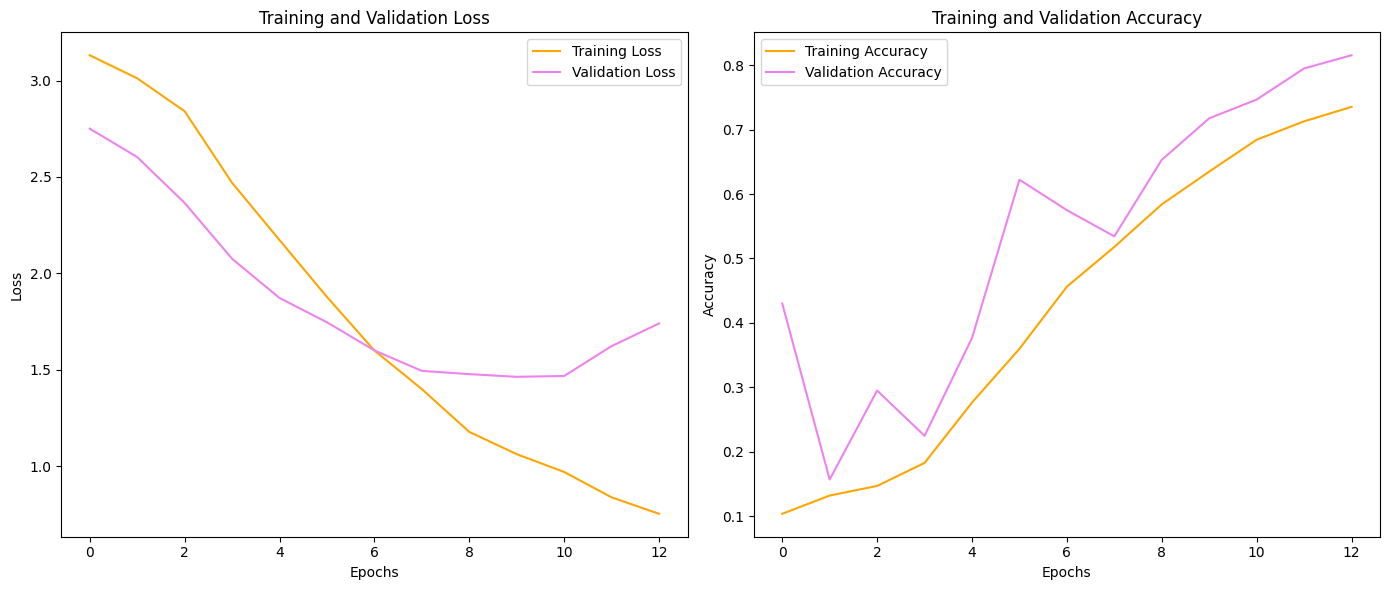

In [13]:
# Traccia la perdita e l'accuratezza
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', color='orange')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='violet')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='orange')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='violet')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


##Evaluation


In [14]:
# Valutazione sul set di validazione
print("Validation Set Evaluation:")
val_loss, val_accuracy = model.evaluate(X_val, y_val, batch_size=32)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Set Evaluation:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7178 - loss: 1.4715
Validation Loss: 1.4631
Validation Accuracy: 0.7175


In [15]:
# Costruzione di id_to_tag
id_to_tag = {i: tag for i, tag in enumerate(label_encoder.classes_)}

# Verifica di id_to_tag
print("id_to_tag:", id_to_tag)


id_to_tag: {0: 'B-Anatomical_system', 1: 'B-Cell', 2: 'B-Cellular_component', 3: 'B-Developing_anatomical_structure', 4: 'B-Immaterial_anatomical_entity', 5: 'B-Multi-tissue_structure', 6: 'B-Organ', 7: 'B-Organism_subdivision', 8: 'B-Organism_substance', 9: 'B-Pathological_formation', 10: 'B-Tissue', 11: 'I-Anatomical_system', 12: 'I-Cell', 13: 'I-Cellular_component', 14: 'I-Developing_anatomical_structure', 15: 'I-Immaterial_anatomical_entity', 16: 'I-Multi-tissue_structure', 17: 'I-Organ', 18: 'I-Organism_subdivision', 19: 'I-Organism_substance', 20: 'I-Pathological_formation', 21: 'I-Tissue', 22: 'O'}


In [16]:
def decode_and_predict(X, y, model, tokenizer, id_to_tag):
    # Decodifica le sequenze di input
    X_decoded = [[tokenizer.index_word[token] for token in sentence if token != 0] for sentence in X]

    # Decodifica le etichette reali
    y_true_decoded = [[id_to_tag[np.argmax(tag)] for tag in sentence] for sentence in y]

    # Predizioni
    y_pred = model.predict(X)
    y_pred_decoded = [[id_to_tag[np.argmax(tag)] for tag in sentence] for sentence in y_pred]

    return X_decoded, y_true_decoded, y_pred_decoded



In [17]:
def compute_class_metrics(y_true, y_pred, id_to_tag):
    # Flatten delle etichette
    y_true_flat = [tag for sentence in y_true for tag in sentence]
    y_pred_flat = [tag for sentence in y_pred for tag in sentence]

    # Calcolo del report
    report = classification_report(y_true_flat, y_pred_flat, target_names=list(id_to_tag.values()))
    print(report)


In [18]:
def plot_conf_matrix(y_true, y_pred, id_to_tag):
    # Flatten delle etichette
    y_true_flat = [tag for sentence in y_true for tag in sentence]
    y_pred_flat = [tag for sentence in y_pred for tag in sentence]

    # Calcola la matrice di confusione
    conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=list(id_to_tag.values()))

    # Visualizza
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(id_to_tag.values()), yticklabels=list(id_to_tag.values()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()



Test Set Analysis:
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                   precision    recall  f1-score   support

              B-Anatomical_system       0.04      0.91      0.07        11
                           B-Cell       0.20      0.59      0.30        96
             B-Cellular_component       0.02      0.44      0.04        25
B-Developing_anatomical_structure       0.20      1.00      0.33        11
   B-Immaterial_anatomical_entity       0.05      0.56      0.09         9
         B-Multi-tissue_structure       0.10      0.22      0.14        97
                          B-Organ       0.57      0.60      0.59        58
           B-Organism_subdivision       0.03      0.43      0.05        14
             B-Organism_substance       0.16      0.56      0.24        34
         B-Pathological_formation       0.08      0.50      0.14        48
                         B-Tissue       0.15      0.29      0.19        28
              I-Anatomical_system       0.04      0.80      0.08         5
                        

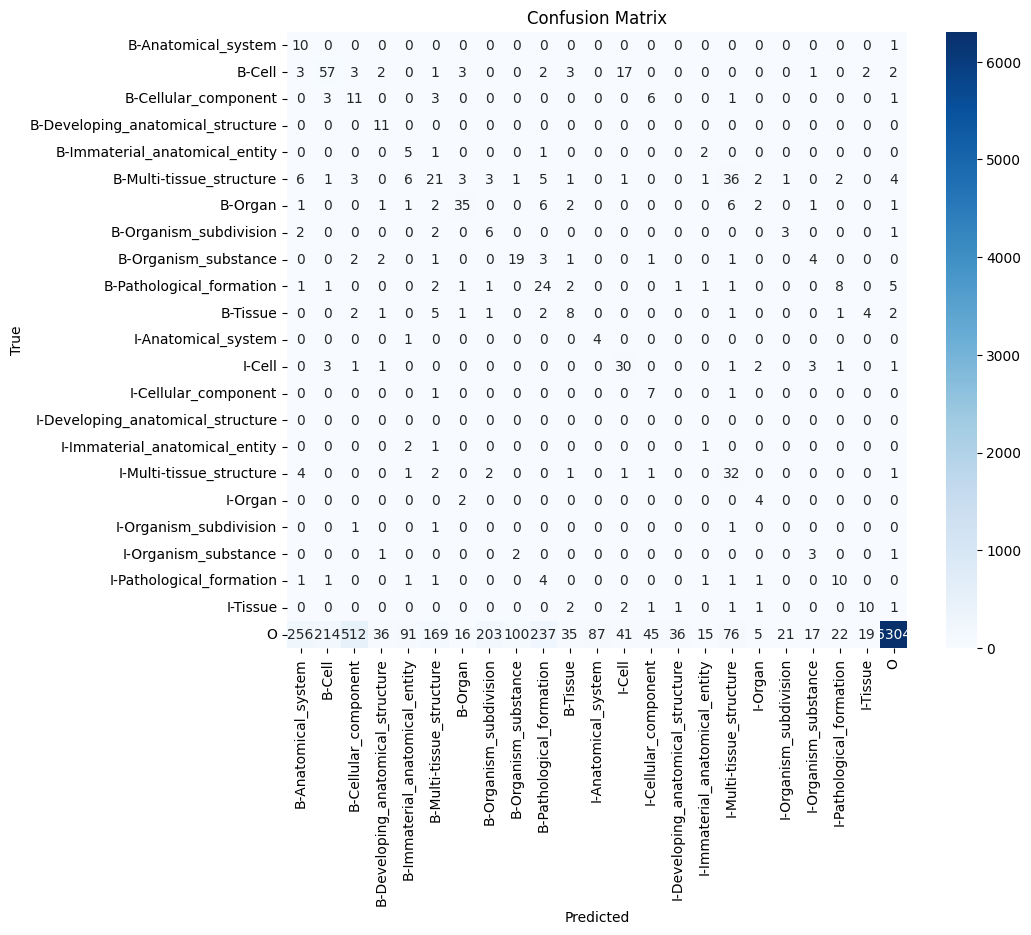

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7193 - loss: 1.3515

Test Loss: 1.5837
Test Accuracy: 0.7226


In [19]:
# Analisi sul set di test
print("\nTest Set Analysis:")
X_test_decoded, y_test_decoded, y_pred_test_decoded = decode_and_predict(X_test, y_test, model, tokenizer, id_to_tag)
compute_class_metrics(y_test_decoded, y_pred_test_decoded, id_to_tag)
plot_conf_matrix(y_test_decoded, y_pred_test_decoded, id_to_tag)

# Accuratezza e perdita sul test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


#Prediction

In [20]:
def predictions(model, X_test, Y_test, tokenizer, id_to_tag):
    tweets = [[tokenizer.index_word[token] for token in sentence if token != 0] for sentence in X_test]
    labels = [[id_to_tag[np.argmax(tag)] for tag in sentence] for sentence in Y_test]
    model_preds = [[id_to_tag[np.argmax(tag)] for tag in sentence] for sentence in model.predict(X_test)]
    return tweets, labels, model_preds


In [21]:
# Predizioni sul test set
tweets, labels, model_preds = predictions(model, X_test, y_test, tokenizer, id_to_tag)

# Stampa esempi
for i, (tweet, label, model_pred) in enumerate(zip(tweets, labels, model_preds)):
    print(f"Tweet: {i + 1}")
    print("Tokens:", " ".join(tweet))
    print("True Labels:", label)
    print("Predicted Labels:", model_pred)
    print("\n")
    if i == 5:  # Limita il numero di esempi stampati
        break


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Tweet: 1
Tokens: lesions treated combined methods child died metastases brain obtained data
True Labels: ['B-Pathological_formation', 'O', 'O', 'O', 'O', 'O', 'B-Pathological_formation', 'B-Organ', 'O', 'O']
Predicted Labels: ['I-Pathological_formation', 'B-Pathological_formation', 'O', 'O', 'O', 'B-Pathological_formation', 'B-Pathological_formation', 'B-Organ', 'B-Pathological_formation', 'B-Anatomical_system']


Tweet: 2
Tokens: loop derivative 6 forms homodimers steric reasons stoichiometric mixture open
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'B-Immaterial_anatomical_entity', 'O', 'O', 'O', 'O']


Tweet: 3
Tokens: finally understanding underlying mechanisms reduced bcm response inappropriate perinatal nutrition
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'B-Cellular_component', 'O', 'O', 'O', 'O']


Tweet: 4
Token